In [12]:


import sys
from PIL import Image
from saliency.dataset import SaliencyDataset
from saliency.metrics import SEQUENTIAL_METRICS, make_engine, multi_match
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import matplotlib



In [ ]:
metrics = SEQUENTIAL_METRICS


metrics_names = ['EUC', 'MAN', 'EYE', 'LEV', 'SMT', 'HAU', 'FRE', 'DTW']
metrics_names += ['TDE', 'REC', 'DET', 'LAM', 'CORM', 'MM_S', 'MM_A']
metrics_names += ['MM_L', 'MM_P', 'MM_D']




dataset = SaliencyDataset()
dataset.load('OSIE')
target = dataset.get('heatmap_path')
dataset_size = len(dataset)
seqs = dataset.get('sequence', modify='remove')
eng = make_engine()


io_h_h = np.zeros((len(dataset), 15, 14, len(metrics) + 4))
corr = np.zeros((io_h_h.shape[-1], io_h_h.shape[-1]))


path = '/home/ramin/codes/SaliencyBundle/results/OSIE/'


In [ ]:

for img_idx, img in enumerate(seqs[]):
	print(img_idx)
	img_size = dataset.data[img_idx]['img_size']
	for main_user_idx, main_user in enumerate(img):
		flag = 0
		for user_idx, user in enumerate(img):
			if user_idx == main_user_idx:
				flag = 1
				continue
			if flag:
				user_idx = user_idx - 1
			for metric_idx, metric in enumerate(metrics):
# 					if metric not in [MultiMatch, ScanMatch]:
# 							continue
					tmp = metric(P=main_user[:,:2], Q=user[:,:2],
							height=img_size[0], width=img_size[1], matlab_engine=eng, threshold=2*24)
					if isinstance(np.array(tmp).flatten(), np.float64):
						print(img_idx, main_user_idx, user_idx, metric_idx)
					if metric != multi_match:
						io_h_h[img_idx, main_user_idx, user_idx, metric_idx] = tmp
					else:
						io_h_h[img_idx, main_user_idx, user_idx, metric_idx:] = np.array(tmp).flatten()
                        
                        
with open('results/io_h_h.npz', 'wb') as f:
	np.save(f, io_h_h)


In [ ]:


for i in range(io_h_h.shape[-1]):
	for j in range(io_h_h.shape[-1]):
		a = io_h_h[:,:,:,i].flatten()
		b = io_h_h[:,:,:,j].flatten()
		mask = (a == 0)
		mask = np.logical_or(mask, b==0)
		mask = np.logical_or(mask, np.isnan(a))
		mask = np.logical_or(mask, np.isnan(b)) 
		corr[i,j] = spearmanr(a[~mask], b[~mask]).correlation
		print(metrics_names[i], metrics_names[j], (~mask).sum(), corr[i,j])

with open('results/seq_corr.npz', 'wb') as f:
	np.save(f, corr)

In [6]:


def heatmap(data, row_labels, col_labels, ax=None,
			cbar_kw={}, cbarlabel="", **kwargs):
	"""
	Create a heatmap from a numpy array and two lists of labels.

	Arguments:
		data       : A 2D numpy array of shape (N,M)
		row_labels : A list or array of length N with the labels
					 for the rows
		col_labels : A list or array of length M with the labels
					 for the columns
	Optional arguments:
		ax         : A matplotlib.axes.Axes instance to which the heatmap
					 is plotted. If not provided, use current axes or
					 create a new one.
		cbar_kw    : A dictionary with arguments to
					 :meth:`matplotlib.Figure.colorbar`.
		cbarlabel  : The label for the colorbar
	All other arguments are directly passed on to the imshow call.
	"""
	if not ax:
		ax = plt.gca()
	# Plot the heatmap
	im = ax.imshow(data, **kwargs)
	# Create colorbar
	cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
	cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
	# We want to show all ticks...
	ax.set_xticks(np.arange(data.shape[1]))
	ax.set_yticks(np.arange(data.shape[0]))
	# ... and label them with the respective list entries.
	ax.set_xticklabels(col_labels)
	ax.set_yticklabels(row_labels)
	# Let the horizontal axes labeling appear on top.
	ax.tick_params(top=True, bottom=False,
				   labeltop=True, labelbottom=False)
	# Rotate the tick labels and set their alignment.
	plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
			 rotation_mode="anchor")
	# Turn spines off and create white grid.
	for edge, spine in ax.spines.items():
		spine.set_visible(False)
	ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
	ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
	ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
	ax.tick_params(which="minor", bottom=False, left=False)
	return im, cbar



def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
					 textcolors=["black", "white"],
					 threshold=None, **textkw):
	"""
	A function to annotate a heatmap.

	Arguments:
		im         : The AxesImage to be labeled.
	Optional arguments:
		data       : Data used to annotate. If None, the image's data is used.
		valfmt     : The format of the annotations inside the heatmap.
					 This should either use the string format method, e.g.
					 "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
		textcolors : A list or array of two color specifications. The first is
					 used for values below a threshold, the second for those
					 above.
		threshold  : Value in data units according to which the colors from
					 textcolors are applied. If None (the default) uses the
					 middle of the colormap as separation.

	Further arguments are passed on to the created text labels.
	"""
	if not isinstance(data, (list, np.ndarray)):
		data = im.get_array()
	# Normalize the threshold to the images color range.
	if threshold is not None:
		threshold = im.norm(threshold)
	else:
		threshold = im.norm(data.max())/2.
	# Set default alignment to center, but allow it to be
	# overwritten by textkw.
	kw = dict(horizontalalignment="center",
			  verticalalignment="center")
	kw.update(textkw)
	# Get the formatter in case a string is supplied
	if isinstance(valfmt, str):
		valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
	# Loop over the data and create a `Text` for each "pixel".
	# Change the text's color depending on the data.
	texts = []
	for i in range(data.shape[0]):
		for j in range(data.shape[1]):
			kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
			text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
			texts.append(text)
	return texts




/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:95: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


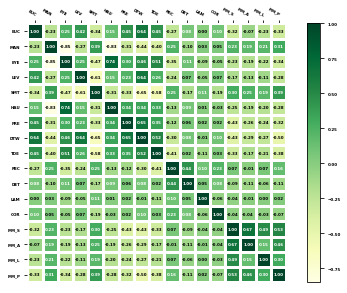

In [19]:
corr = np.load('results/seq_corr.npz')
metrics_names = ['EUC', 'MAN', 'EYE', 'LEV', 'SMT', 'HAU', 'FRE', 'DTW']
metrics_names += ['TDE', 'REC', 'DET', 'LAM', 'COR', 'MM_S', 'MM_A']
metrics_names += ['MM_L', 'MM_P']



font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 4}

matplotlib.rc('font', **font)

fig, ax = plt.subplots()

im, cbar = heatmap(corr[:-1,:-1], metrics_names, metrics_names, ax=ax, cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
# plt.show()
plt.savefig('figs/3-3-seq_corr.png', dpi=300)
